In [53]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation as R

In [54]:
data_path = 'C:\\Users\\flipe\\AppData\\LocalLow\\Warehouse\\VR-tennis\\Data'
subject_paths = [f.name for f in os.scandir(data_path) if f.is_dir()]

dfs_ball = {}

for subject in subject_paths:
    subject_dir = os.path.join(data_path, subject)
    csv_files = [f for f in os.listdir(subject_dir) if f.endswith('.csv')]
    ball_tracker_files = [f for f in csv_files if 'ball-tracker' in f]
    if ball_tracker_files:
        csv_path = os.path.join(subject_dir, ball_tracker_files[0])
        dfs_ball[subject] = pd.read_csv(csv_path)
        print(f"Loaded ball-tracker for {subject}")
    else:
        print(f"No ball-tracker CSV found for {subject}")

subject_count = len(dfs_ball)

Loaded ball-tracker for Charline_R_vr3_3_2025-06-23_15-12-35
Loaded ball-tracker for FilipeMendes_R_vr8_4_2025-06-24_11-07-13
Loaded ball-tracker for FlipeRodrigues1_R_vr7_8_2025-06-24_11-44-15
Loaded ball-tracker for FlipeRodrigues2_R_vr7_8_2025-06-24_12-13-46
Loaded ball-tracker for Francisco_R_vr7_9_2025-06-23_17-46-16
Loaded ball-tracker for Joseph_R_vr3_8_2025-06-24_10-43-38
Loaded ball-tracker for Juan_R_vr6_8_2025-06-24_10-20-07
Loaded ball-tracker for Livia_R_vr1_1_2025-06-23_14-25-13
Loaded ball-tracker for Manel_R_vr1_8_2025-06-23_17-27-27
Loaded ball-tracker for Matilde_R_vr4_2_2025-06-23_18-07-04
No ball-tracker CSV found for OLD
Loaded ball-tracker for Paco_R_vr6_4_2025-06-23_14-50-50
Loaded ball-tracker for Rodrigo_R_vr2_9_2025-06-23_18-26-20
Loaded ball-tracker for Simon_R_vr4_7_2025-06-23_15-42-46


In [55]:
time2exclude = 60

# Exclude data before the specified time
for subject in dfs_ball:
    mask = dfs_ball[subject]['time'] >= time2exclude
    dfs_ball[subject].loc[~mask, dfs_ball[subject].columns.difference(['time'])] = np.nan

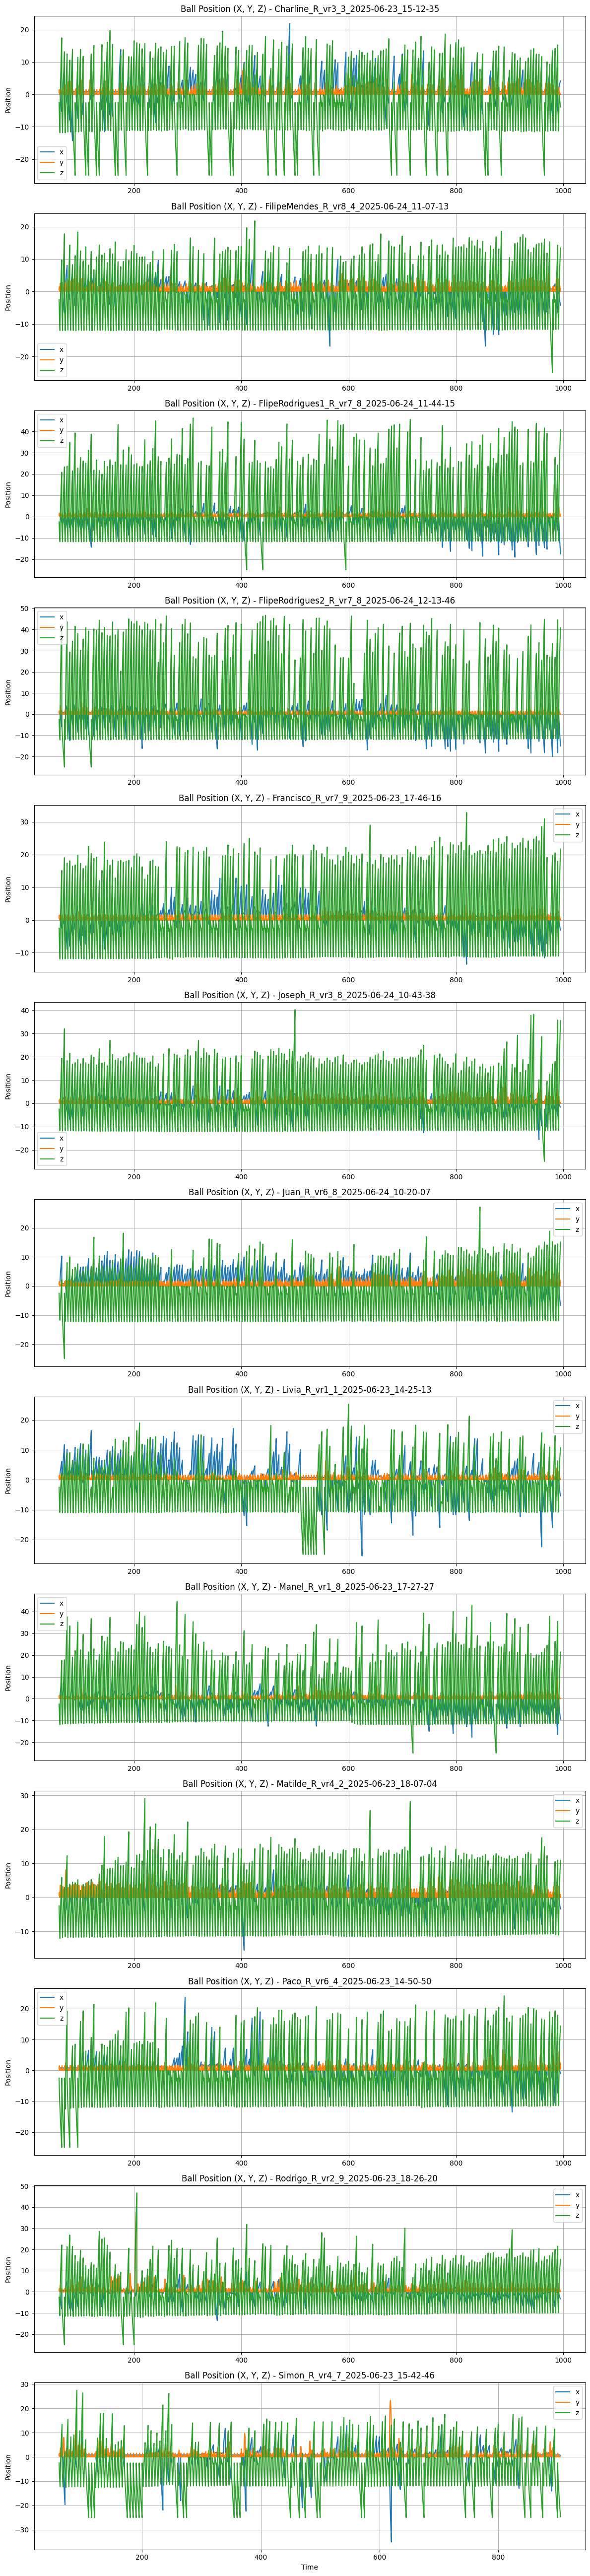

In [56]:
fig, axs = plt.subplots(subject_count, 1, figsize=(12, 4 * subject_count), sharex=False)

for i, subject in enumerate(dfs_ball):
    df = dfs_ball[subject]
    axs[i].plot(df['time'], df['position.x'], label='x')
    axs[i].plot(df['time'], df['position.y'], label='y')
    axs[i].plot(df['time'], df['position.z'], label='z')
    axs[i].set_title(f"Ball Position (X, Y, Z) - {subject}")
    axs[i].set_ylabel('Position')
    axs[i].legend()
    axs[i].grid()

axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

In [57]:
# Extract ball trajectories around RacketHit and following CourtEnter for each subject
trajectories = {}

for subject, df in dfs_ball.items():
    df = df.reset_index(drop=True)

    # Find all RacketHit events
    racket_hit_idcs = df.index[df["event"] == "RacketHit"].tolist()
    subject_trajs = []
    for racket_hit_idx in racket_hit_idcs:
        racket_hit_time = df.loc[racket_hit_idx, "time"]

        # Find the first CourtEnter after this RacketHit
        court_enter_idxs = df.index[
            (df["event"] == "CourtEnter") & (df["time"] > racket_hit_time)
        ].tolist()
        if not court_enter_idxs:
            continue  # No CourtEnter after this hit
        court_enter_idx = court_enter_idxs[0]
        court_enter_time = df.loc[court_enter_idx, "time"]

        # Define time window
        t_start = racket_hit_time
        t_end = court_enter_time

        # Extract trajectory within this window
        traj_mask = (df["time"] >= t_start) & (df["time"] <= t_end)
        traj = df.loc[traj_mask].copy()
        traj["event_window"] = ""
        traj.loc[racket_hit_idx, "event_window"] = "RacketHit"
        traj.loc[court_enter_idx, "event_window"] = "CourtEnter"
        subject_trajs.append(traj)

    # Store trajectories for this subject
    trajectories[subject] = subject_trajs

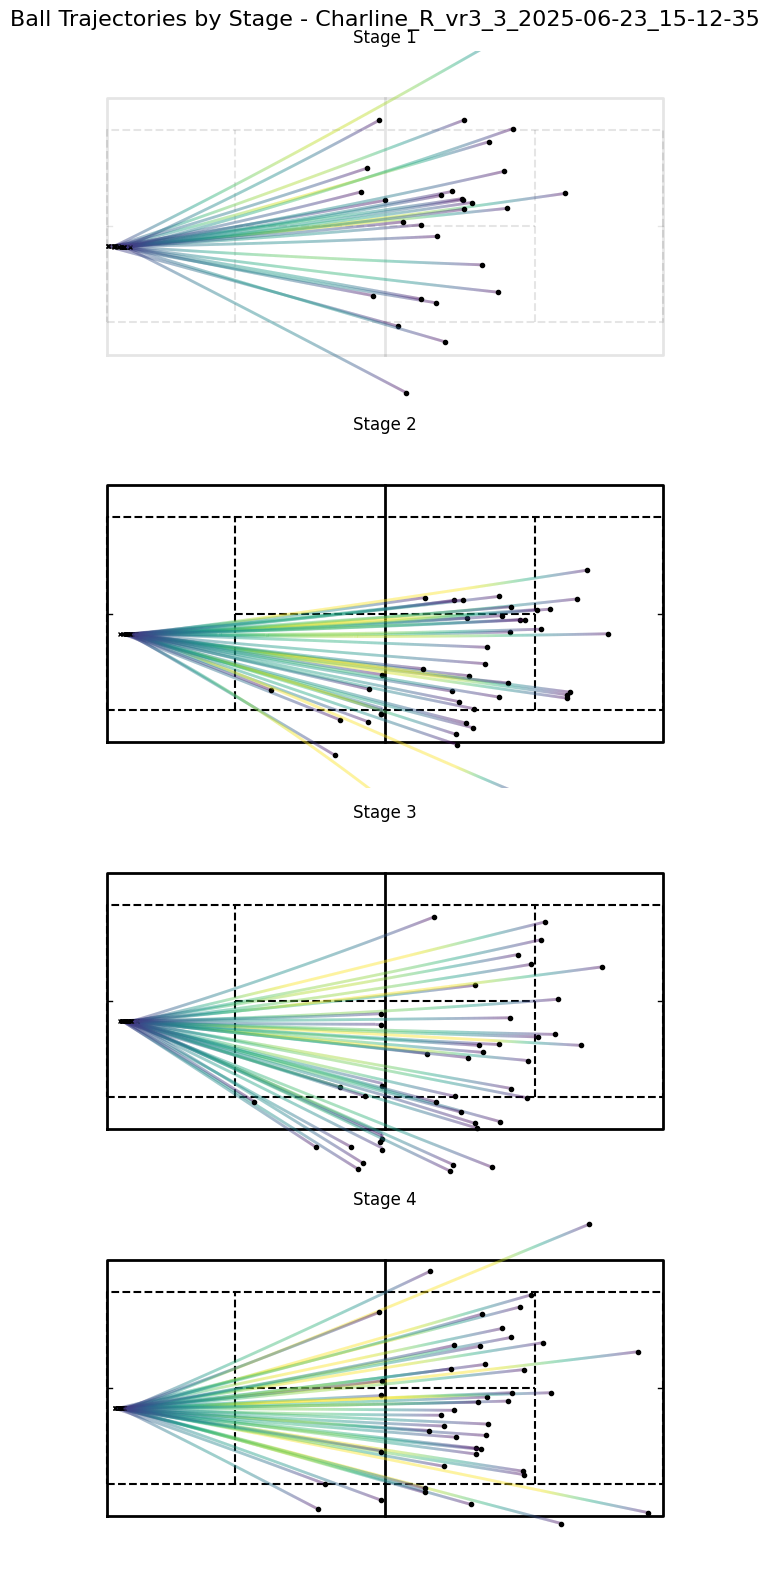

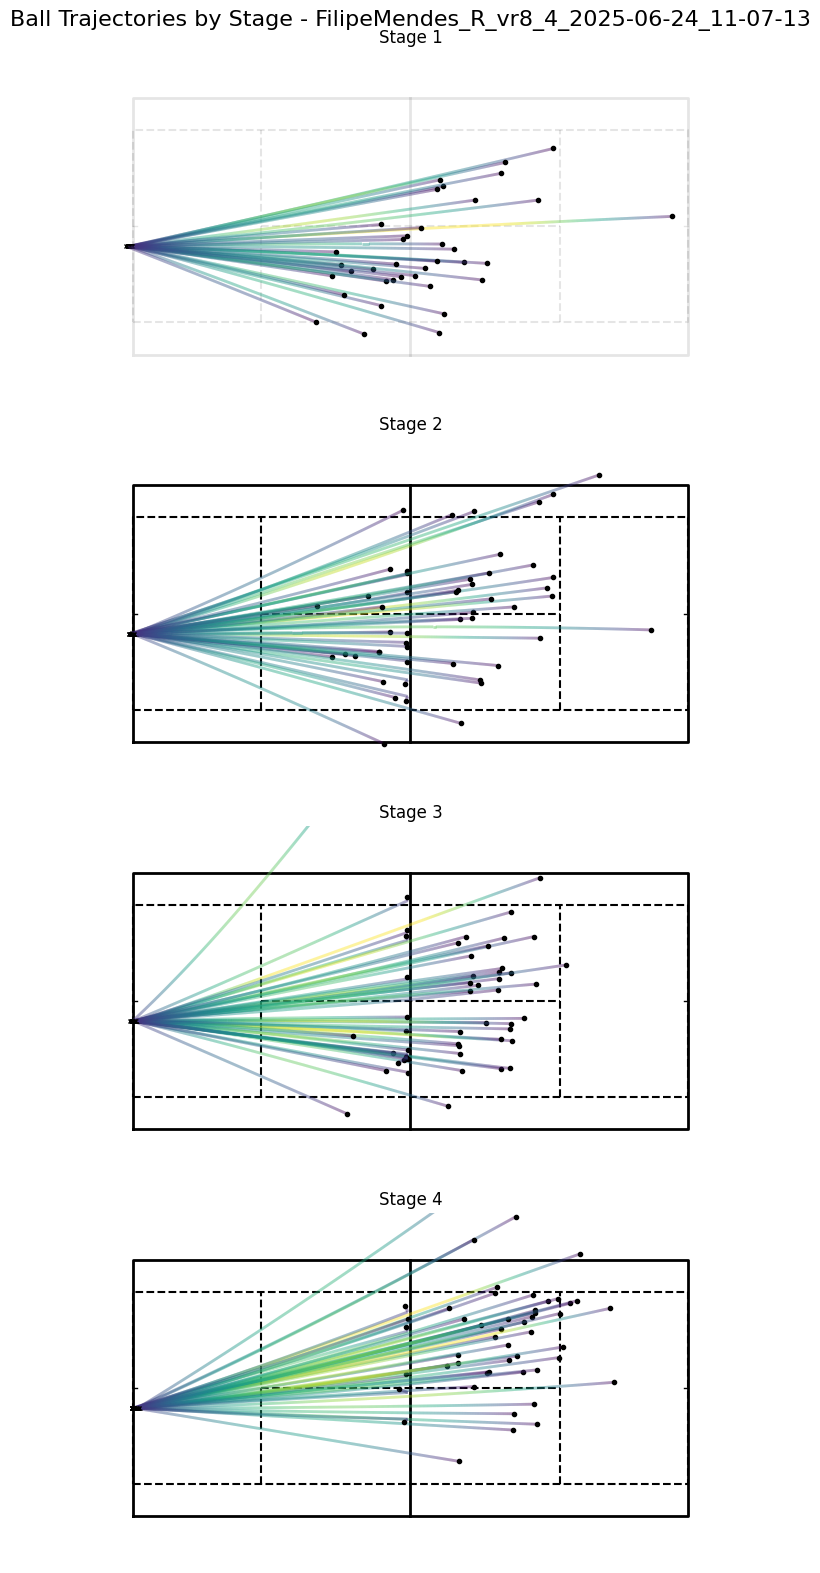

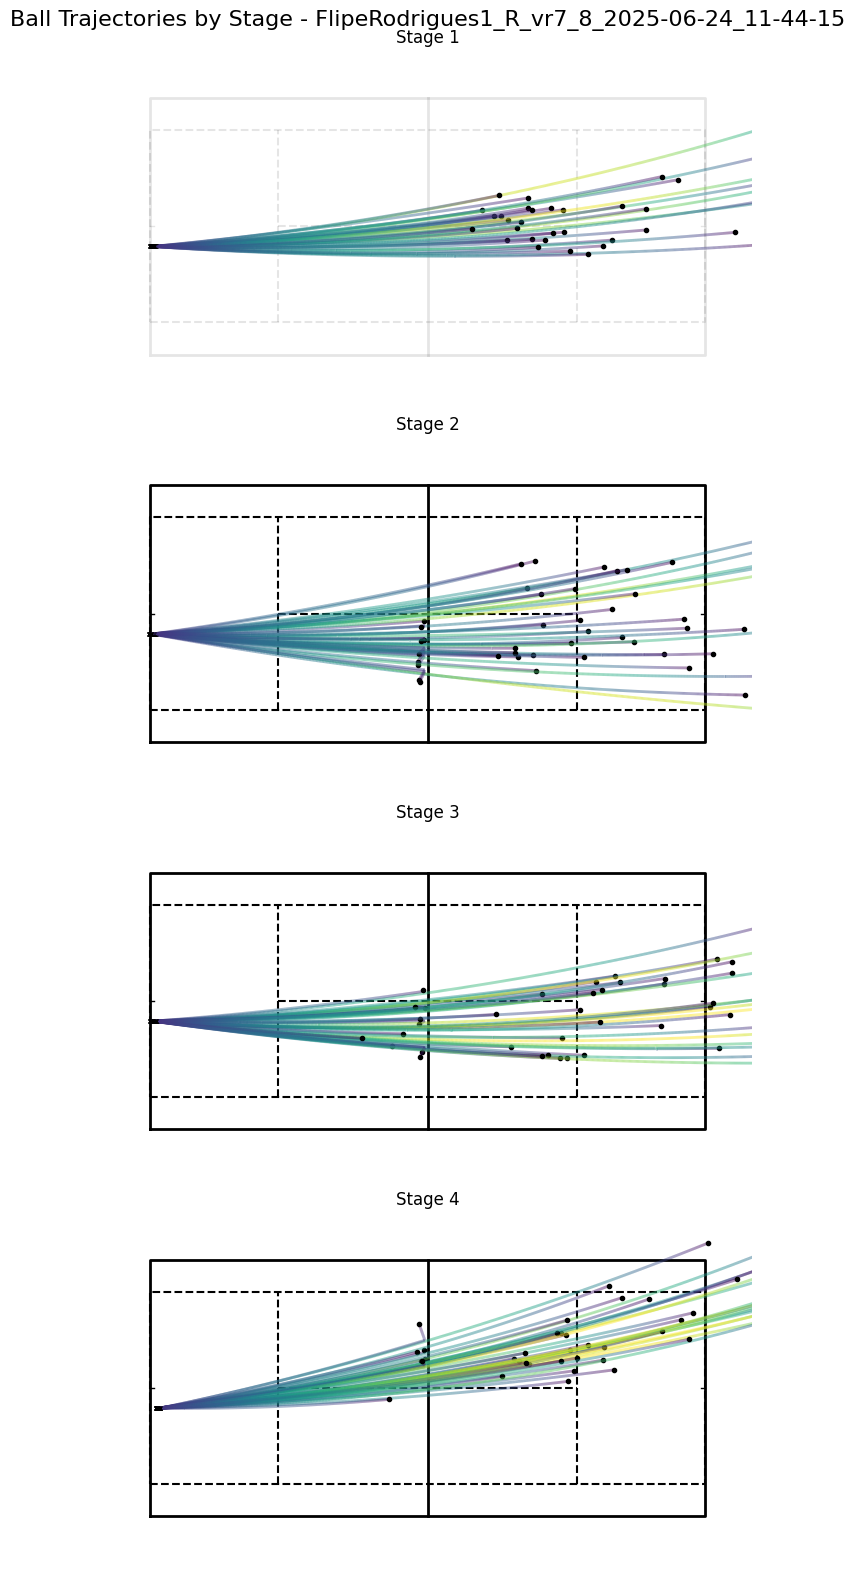

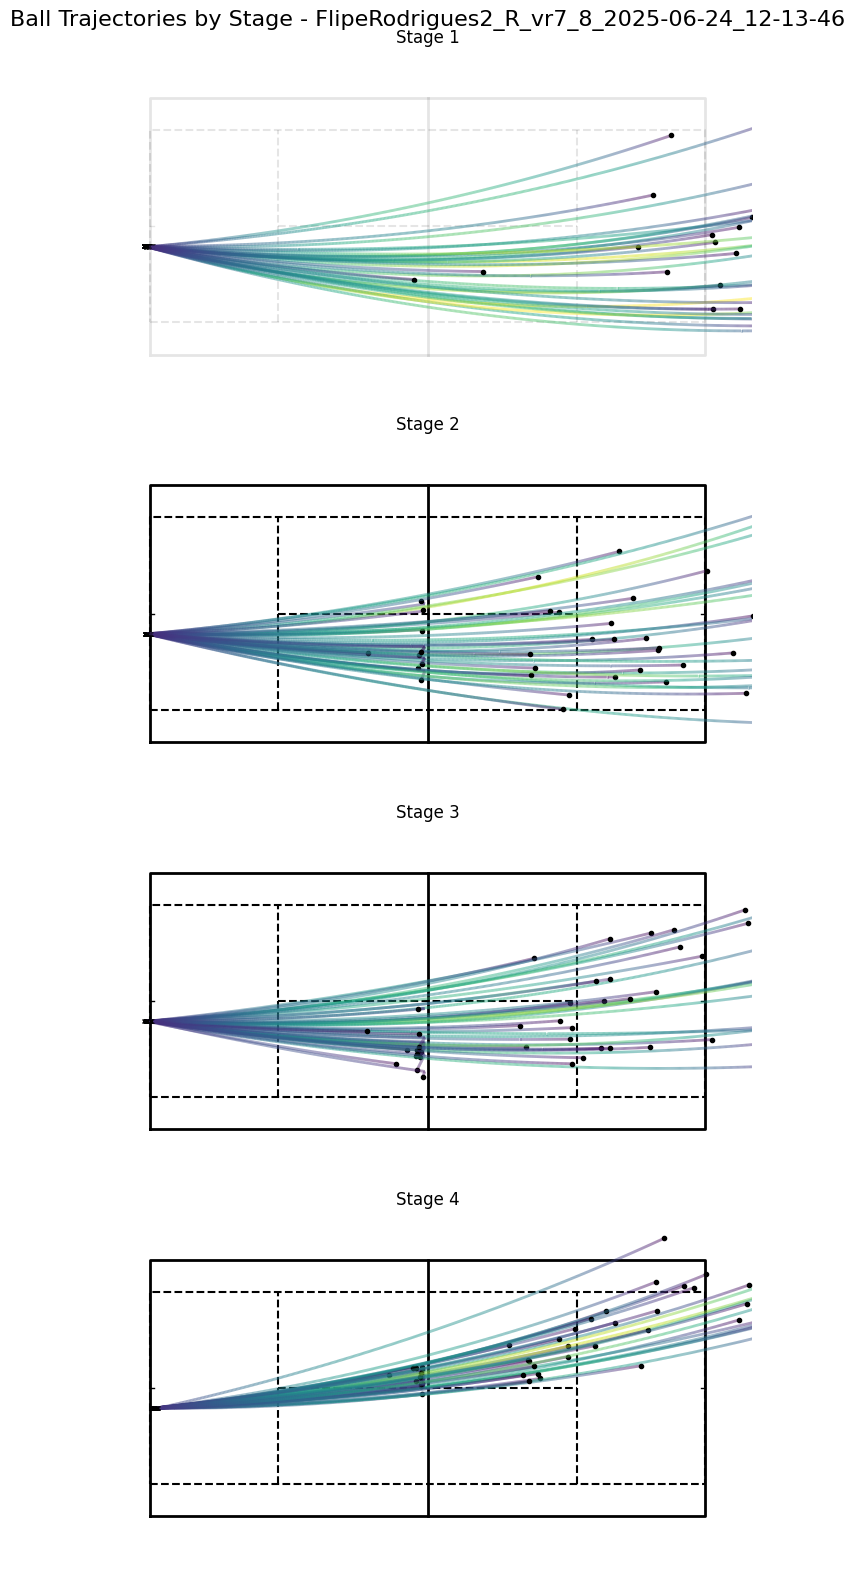

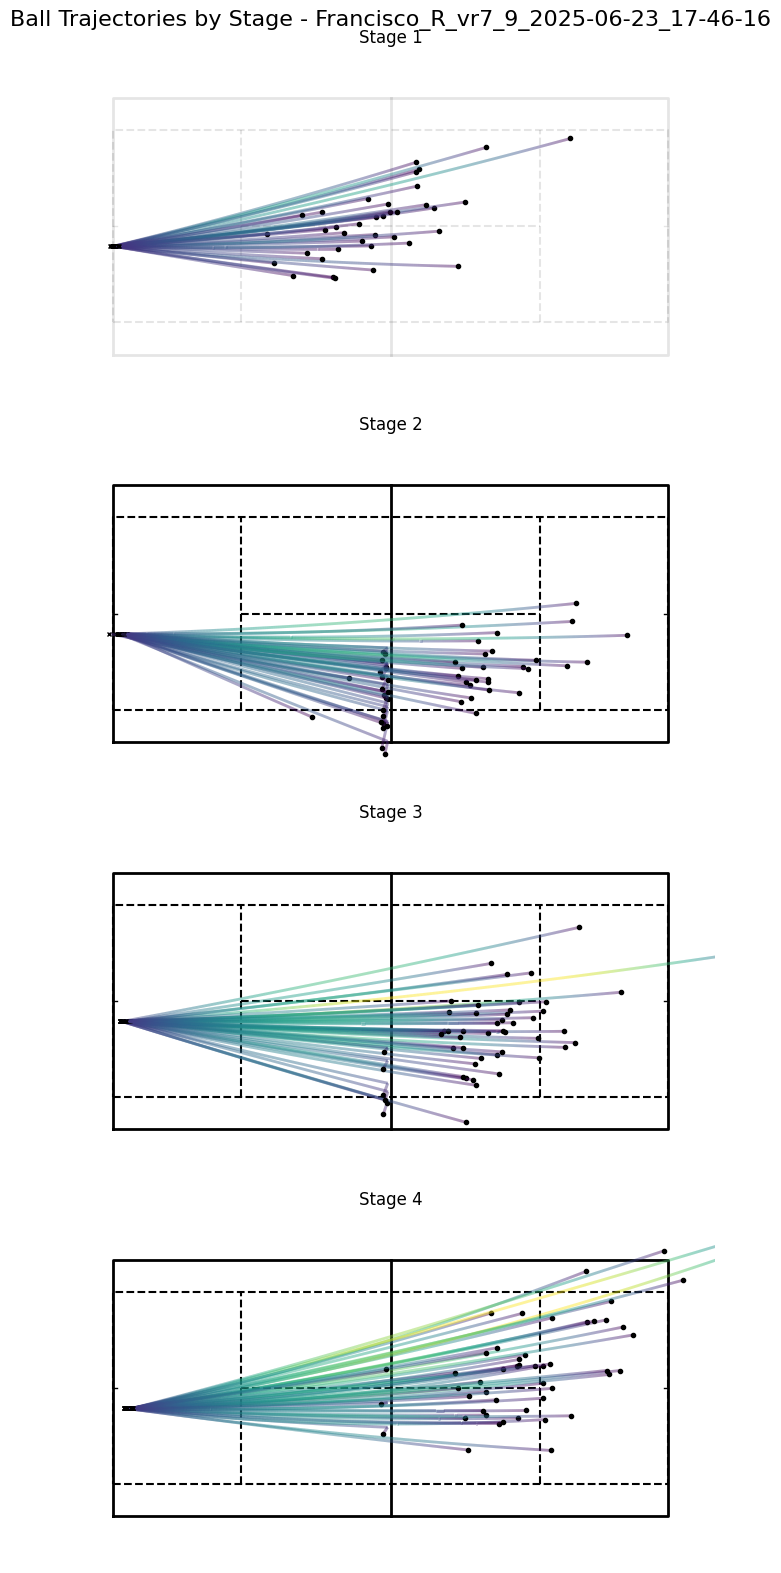

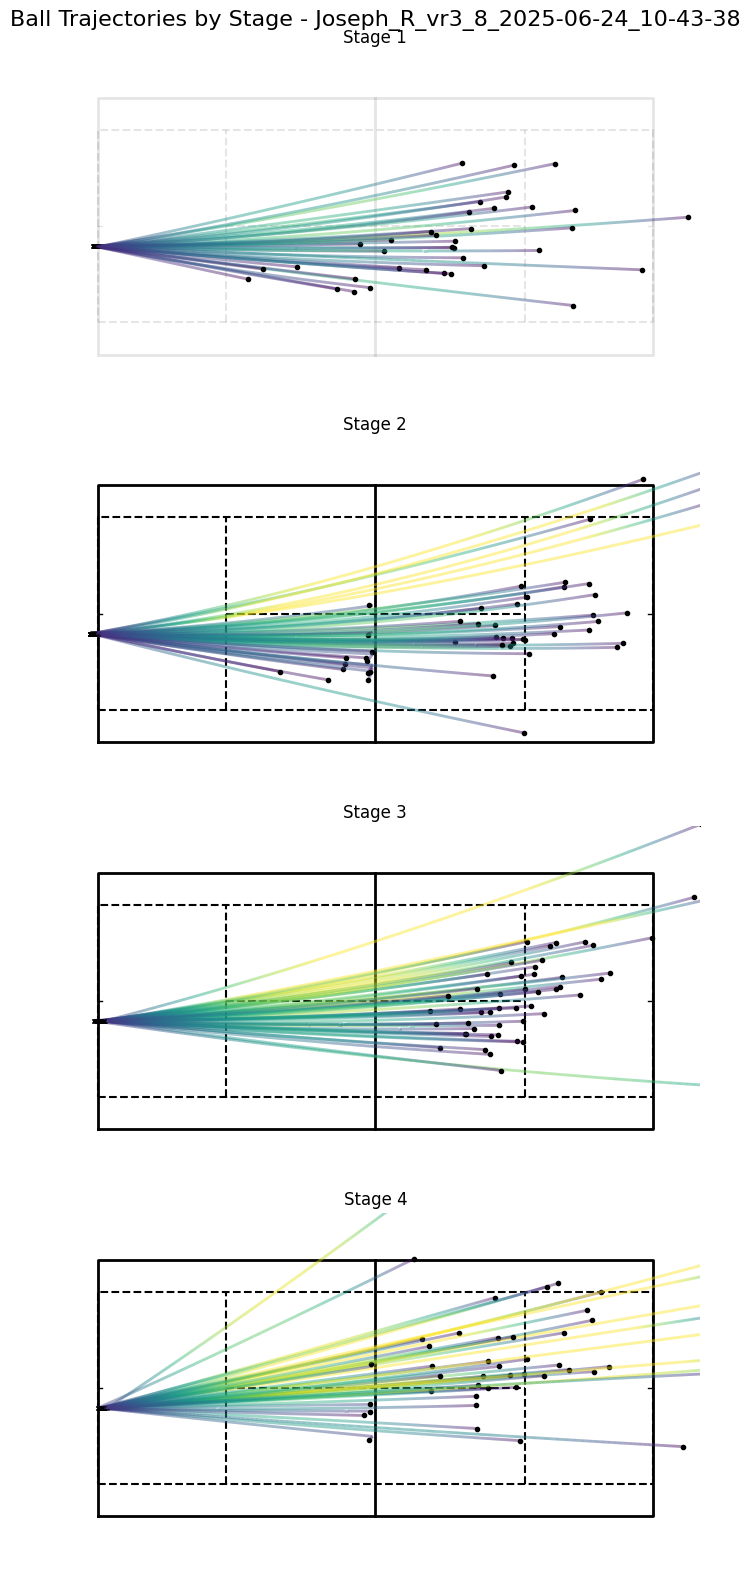

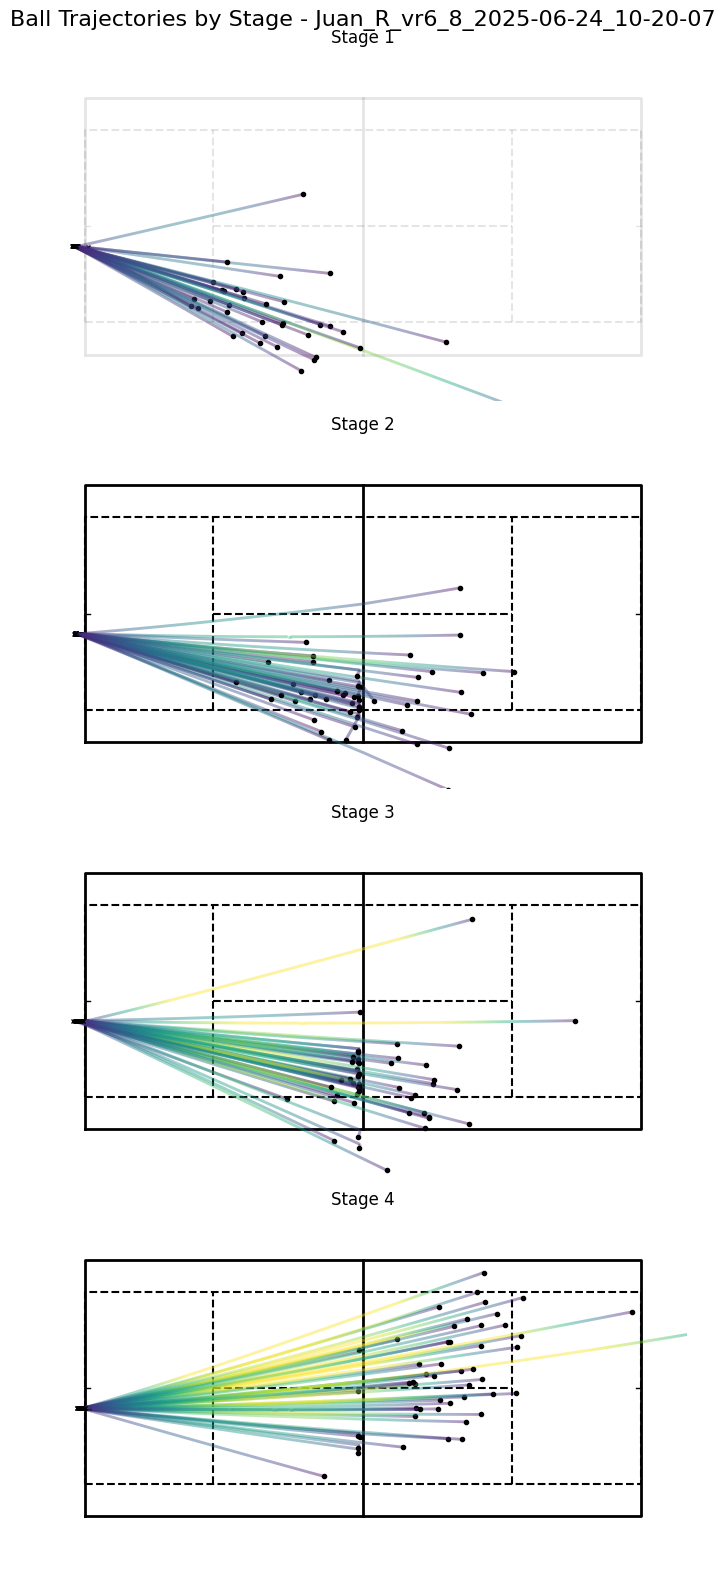

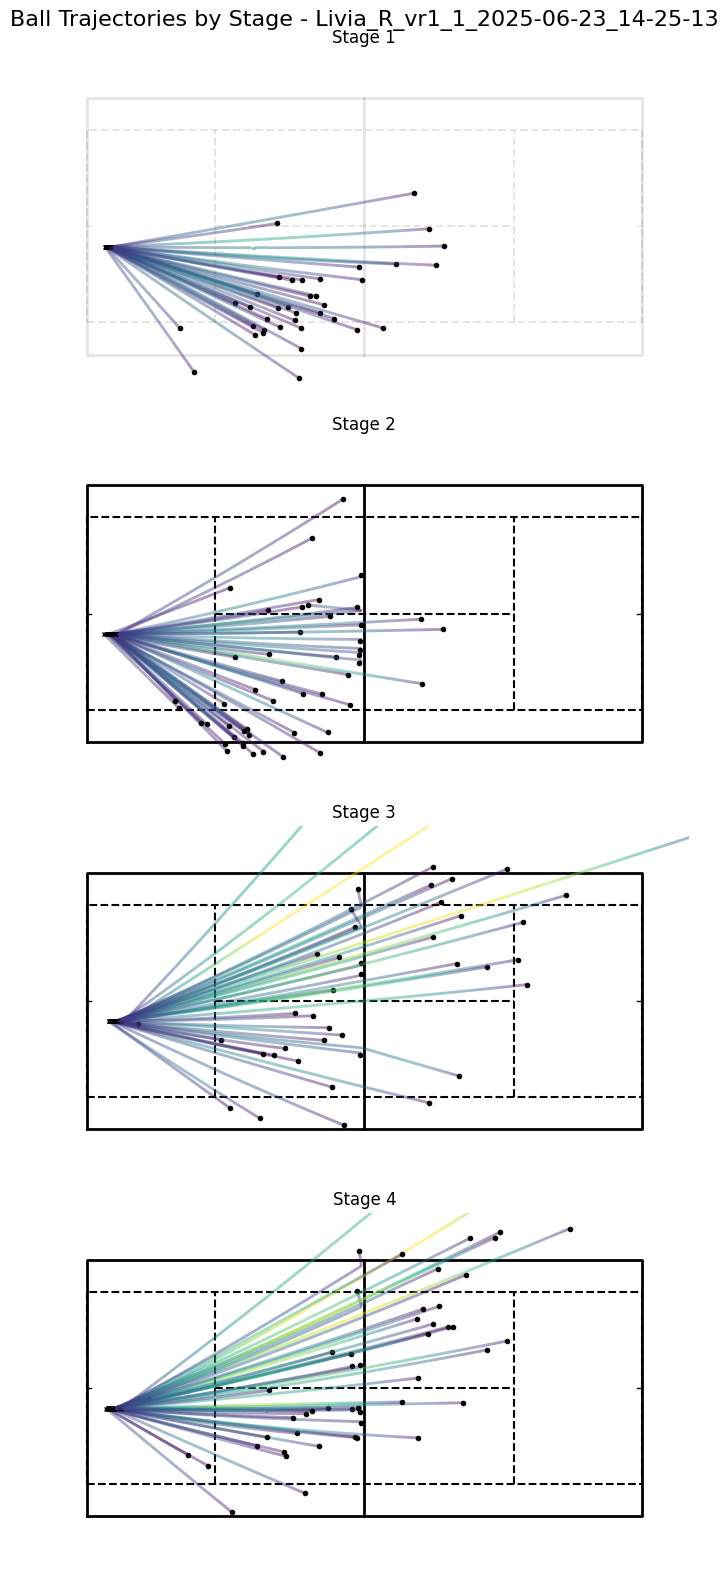

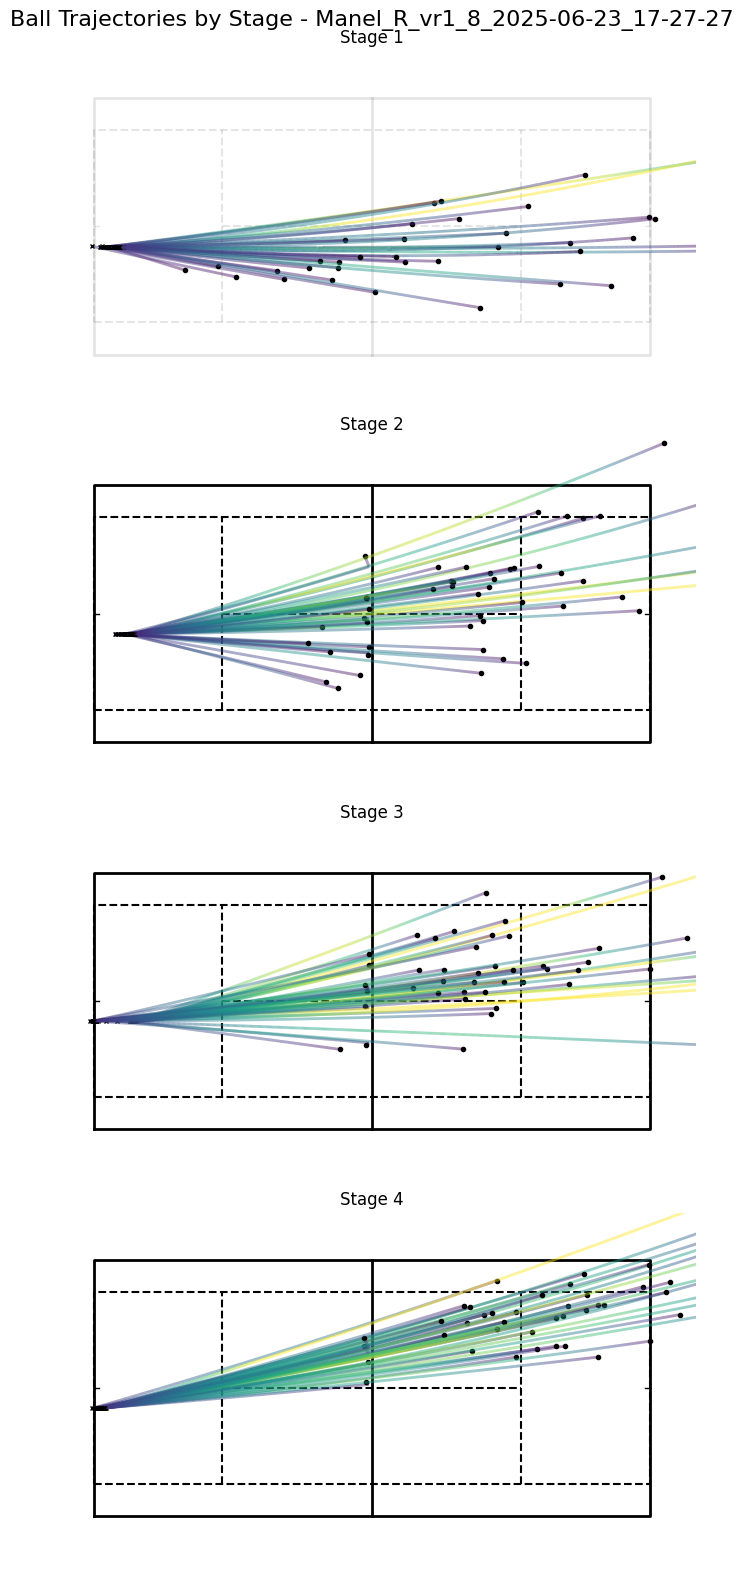

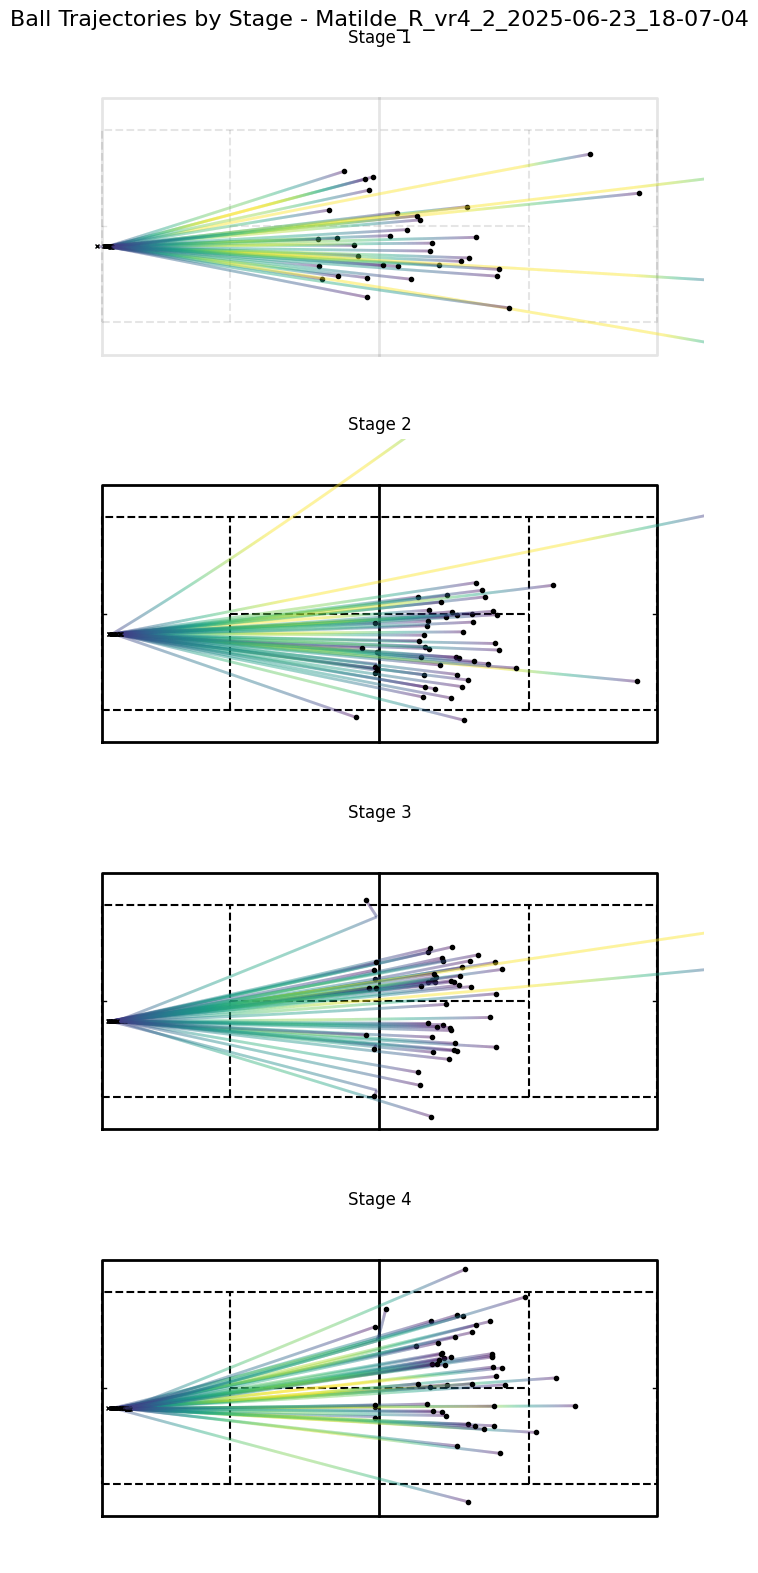

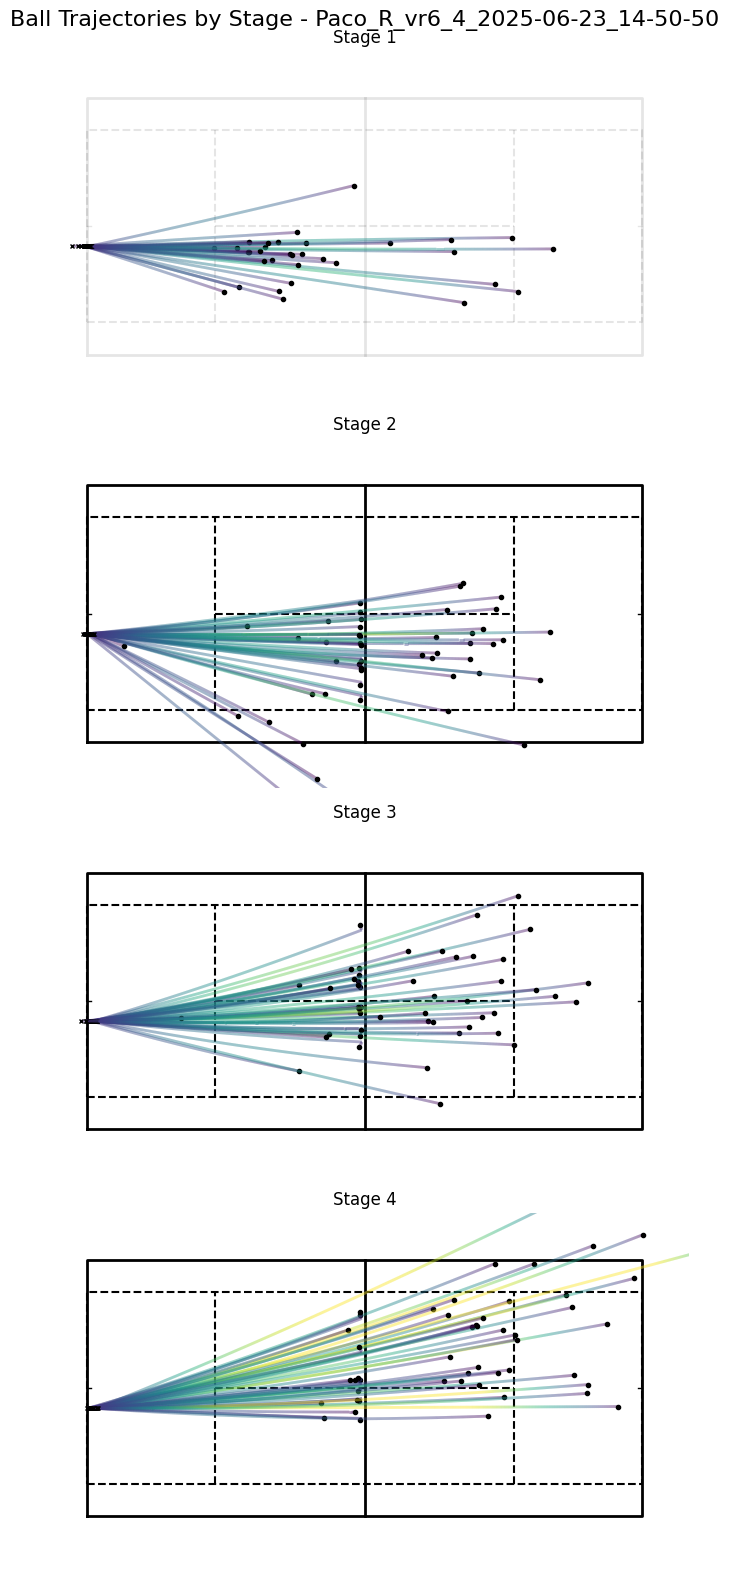

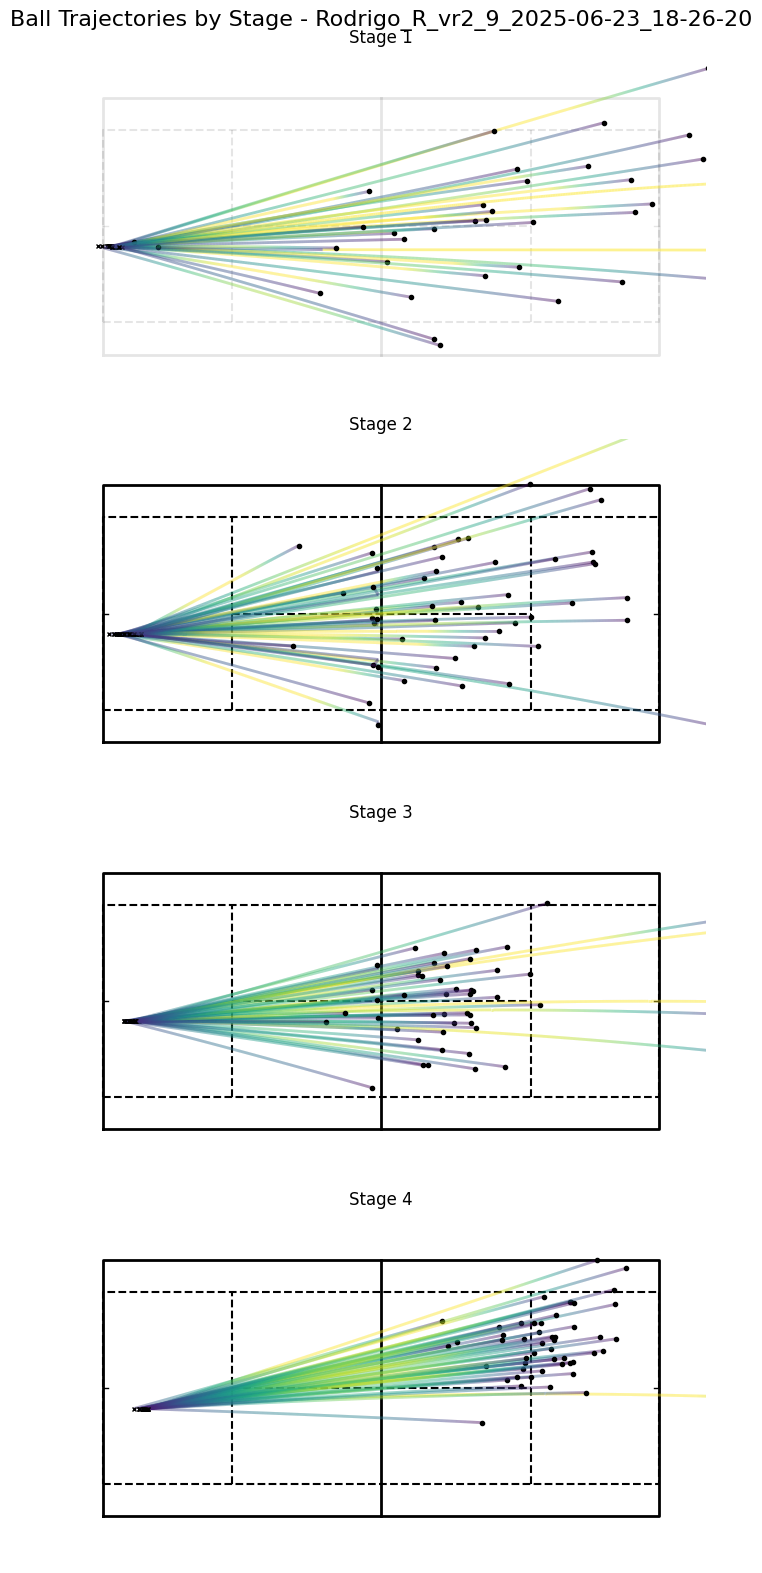

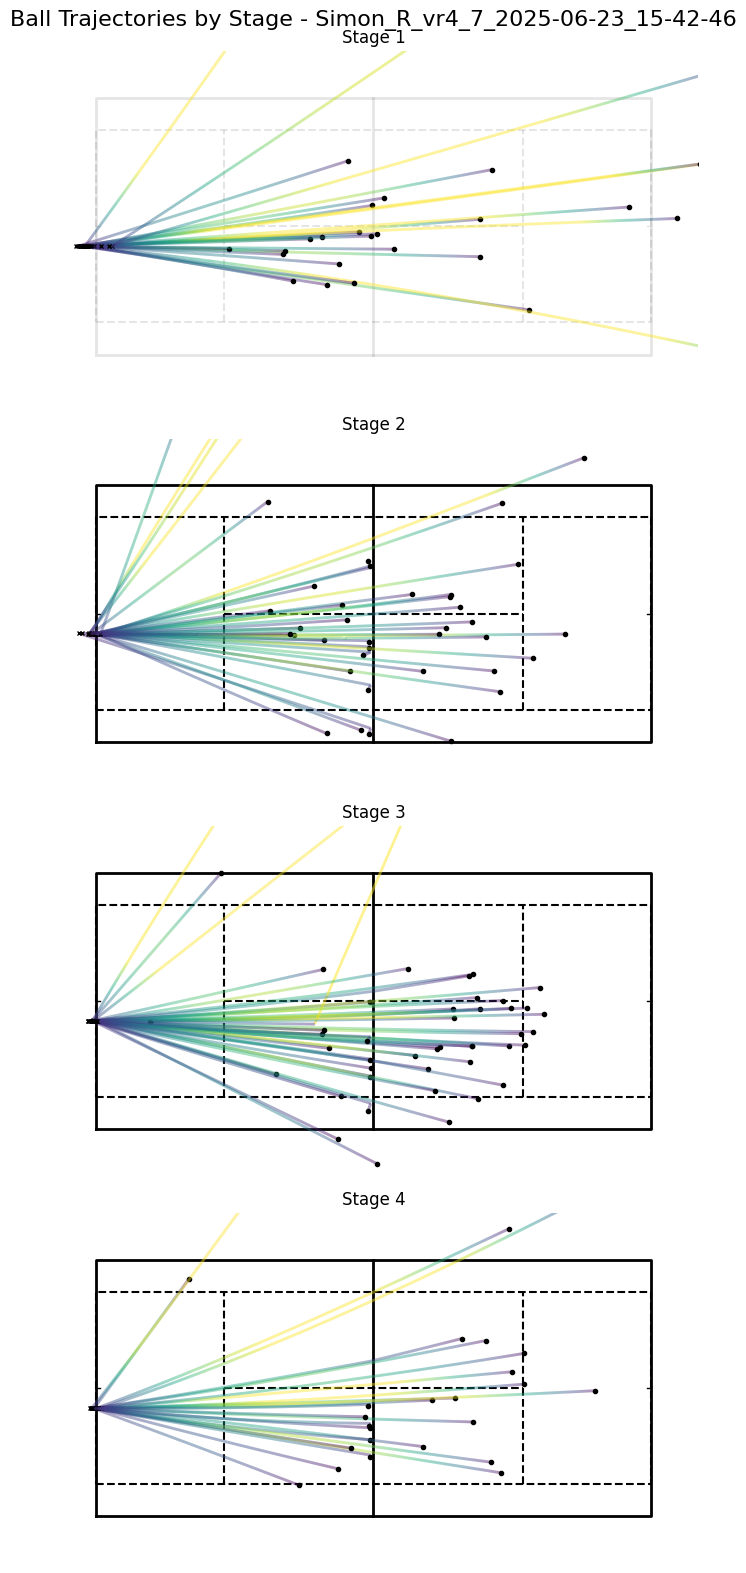

In [63]:
# Tennis court dimensions in meters (ITF standard, singles and doubles)
court_length = 23.77
court_width_singles = 8.23
court_width_doubles = 10.97
service_line_dist = 6.40  # Distance from net to service line
net_x = court_length / 2


def plot_tennis_court(ax, alpha=1.0):
    # Rotate court by 90º: swap x and y, and flip y to keep orientation
    # Court outline (doubles)
    ax.plot(
        [
            -court_length / 2,
            court_length / 2,
            court_length / 2,
            -court_length / 2,
            -court_length / 2,
        ],
        [
            -court_width_doubles / 2,
            -court_width_doubles / 2,
            court_width_doubles / 2,
            court_width_doubles / 2,
            -court_width_doubles / 2,
        ],
        color="black",
        alpha=alpha,
        lw=2,
    )
    # Singles lines
    ax.plot(
        [
            -court_length / 2,
            court_length / 2,
            court_length / 2,
            -court_length / 2,
            -court_length / 2,
        ],
        [
            -court_width_singles / 2,
            -court_width_singles / 2,
            court_width_singles / 2,
            court_width_singles / 2,
            -court_width_singles / 2,
        ],
        color="black",
        alpha=alpha,
        lw=1.5,
        ls="--",
    )
    # Net
    ax.plot(
        [0, 0],
        [-court_width_doubles / 2, court_width_doubles / 2],
        color="black",
        alpha=alpha,
        lw=2,
    )
    # Service lines
    ax.plot(
        [-service_line_dist, -service_line_dist],
        [-court_width_singles / 2, court_width_singles / 2],
        color="black",
        alpha=alpha,
        ls="--",
    )
    ax.plot(
        [service_line_dist, service_line_dist],
        [-court_width_singles / 2, court_width_singles / 2],
        color="black",
        alpha=alpha,
        ls="--",
    )
    # Center service line
    ax.plot(
        [-service_line_dist, service_line_dist],
        [0, 0],
        color="black",
        alpha=alpha,
        ls="--",
    )
    # Center marks
    ax.plot(
        [-court_length / 2, -court_length / 2 + 0.2],
        [0, 0],
        color="black",
        alpha=alpha,
        lw=1,
    )
    ax.plot(
        [court_length / 2, court_length / 2 - 0.2],
        [0, 0],
        color="black",
        alpha=alpha,
        lw=1,
    )
    # Set limits
    padding = 2.0
    ax.set_xlim(-court_length / 2 - padding, court_length / 2 + padding)
    ax.set_ylim(-court_width_doubles / 2 - padding, court_width_doubles / 2 + padding)
    ax.set_aspect("equal")


# 1. Compute global min and max ball heights
all_heights = []
for subj_trajs in trajectories.values():
    for traj in subj_trajs:
        if "position.y" in traj.columns:
            all_heights.append(traj["position.y"].values)
all_heights = np.concatenate(all_heights)
global_min_height = np.nanmin(all_heights)
global_max_height = np.nanpercentile(all_heights, 95)

# 2. Use these for the colormap normalization in the plotting loop
for subject, trajs in trajectories.items():
    fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=False)
    fig.suptitle(f"Ball Trajectories by Stage - {subject}", fontsize=14)

    for stage in range(1, 5):
        ax = axs[stage - 1]

        plot_tennis_court(ax, alpha=.1 if stage == 1 else 1.0)

        for traj in trajs:
            if "stage" in traj.columns and stage in traj["stage"].unique():
                stage_mask = traj["stage"] == stage
                x_rot = traj.loc[stage_mask, "position.z"]
                y_rot = -traj.loc[stage_mask, "position.x"]
                ball_height = traj.loc[stage_mask, "position.y"]

                points = np.array([x_rot, y_rot]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(
                    segments,
                    cmap="viridis",
                    norm=plt.Normalize(global_min_height, global_max_height),
                )
                lc.set_array(ball_height.values)
                lc.set_linewidth(2)
                lc.set_alpha(0.5)
                ax.add_collection(lc)

                if not x_rot.empty and not y_rot.empty:
                    ax.plot(
                        x_rot.iloc[0],
                        y_rot.iloc[0],
                        color="black",
                        marker="x",
                        markersize=3,
                    )
                    ax.plot(
                        x_rot.iloc[-1],
                        y_rot.iloc[-1],
                        color="black",
                        marker="o",
                        markersize=3,
                    )

        ax.set_title(f"Stage {stage}")
        ax.set_xlabel("Court Length (m)")
        ax.set_ylabel("Court Width (m)")
        ax.axis("off")
        ax.set_clip_on(False)

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()